### **Research question 3 : What is the impact of the director’s character choices on the success of the movie ?**

#### 3.1 What types of characters do successful directors choose ? 
#### 3.2 How diverse the directors are in their character choices ? 
#### 3.3 Can we find very successful directors that always use the same type of characters or others that vary a lot in their personas choices ?
#### 3.4 In definitive, how does this impact the movie’s success ?

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import entropy
import copy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import networkx as nx
from tqdm import tqdm

from helpers.readers import read_dataframe
DATA_PATH = './generated/annotations_2023/'
DATA_PATH_GENERATED = './generated/'

# Load dataset nedded

In [2]:
character_movie_directors_ori=pd.read_parquet(os.path.join(DATA_PATH, "character_movie_directors.parquet"), engine='pyarrow')

In [3]:
character_movie_directors_ori.head()
print('There are {} chractors with chractor types in the dataset'.format(len(character_movie_directors_ori)))

There are 37749 chractors with chractor types in the dataset


In [4]:
# Check for missing values
print(character_movie_directors_ori.isnull().sum())

Wikipedia movie ID       0
Freebase movie ID        0
Movie name               0
Character name           0
tconst                   0
directors                0
freebase                 0
imdb                     0
movieid_charactername    0
topic                    0
topic_dist               0
dtype: int64


In [338]:
cmu_movies = read_dataframe(
    name='cmu/movies',
    preprocess=True,
    usecols=[
        "Wikipedia movie ID",
        "Freebase movie ID",
        "Movie name",
        "Movie release date",
        "Movie box office revenue",
        "Movie runtime",
        "Movie languages",
        "Movie countries",
        "Movie genres",
    ]
)
mapping_f_i = read_dataframe(name='mapping_freebase_imdb')
imdb_ratings = read_dataframe(name='imdb/ratings')
imdb_crew = read_dataframe(name='imdb/crew')
imdb_people = read_dataframe(name='imdb/names')

Preprocess logs:
✅ Fixed Movie Languages inside Movie Countries
✅ Removed Deseret characters
✅ Movie release date splitted to three columns: Movie release Year, Movie release Month, Movie release Day
✅ Fixed 'Hunting Season' release year 1010 => 2010
✅ Seperated freebase identifiers from Movie Languages, Movie Countries and Movie Genres
✅ Replaced Hariyani with Haryanvi
✅ Replaced Saami with Sami
✅ The Flying Scotsman (1929 film) country fix
✅ Ukranian SSR fix
✅ Palestinian territories fix
✅ Fixed huge runtimes
✅ Removed series


In [339]:
movies = cmu_movies.drop(['Movie release Day', 'Movie release Month'], axis=1).copy()
movies.rename(
    columns={
        'Wikipedia movie ID': 'wikipediaID',
        'Freebase movie ID': 'freebaseID',
        'Movie name': 'title',
        'Movie box office revenue': 'revenue',
        'Movie runtime': 'runtime',
        'Movie languages': 'languages',
        'Movie countries': 'countries',
        'Movie genres': 'genres',
        'Movie release Year': 'release',
    },
    inplace=True,
)
movies = movies.merge(
    right=mapping_f_i.drop_duplicates(subset='freebase'),
    left_on='freebaseID', right_on='freebase', how='left'
).rename(columns={'imdb': 'tconst'}).drop('freebase', axis=1)
movies.tconst.duplicated().sum()
movies.drop_duplicates(subset='tconst', inplace=True)
movies = movies.merge(
    right=imdb_ratings.rename(columns={'averageRating': 'rating', 'numVotes': 'votes'}),
    on='tconst', how='left',
)
movies = movies.merge(right=imdb_crew.drop('writers', axis=1), on='tconst', how='left')
movies = movies.set_index('tconst')

In [340]:
nmconsts = []
for item in movies.dropna(subset='directors').directors.str.split(','):
    nmconsts.extend(item)
nmconsts = set(nmconsts)

directors = imdb_people[imdb_people.nconst.isin(nmconsts)].copy()
directors = directors.set_index('nconst')

In [343]:
# !pip install memory_profiler
# install and load memory_profiler to use %memit, use %whos to see what's in memory
%reload_ext memory_profiler
%memit
import gc

del imdb_people
del mapping_f_i
del cmu_movies
del imdb_ratings
del imdb_crew

gc.collect()
%memit

peak memory: 4984.96 MiB, increment: 0.00 MiB
peak memory: 3478.03 MiB, increment: 0.00 MiB


# 3.1 What types of characters do successful directors choose ? 

First, we need to establish a metric to measure movie sucess, and based one it we can assess director success. Drawing upon past exploration and the definition of director success, we can generate the following dataframe containing success scores for directors.

In [341]:
#Define a function to calculate the score of a movie
def metric(row):
    return np.log10(row['votes']) * row['rating']

movies['score'] = movies.apply(metric, axis=1)

In [342]:
movies.to_parquet(os.path.join(DATA_PATH_GENERATED, "movie_with_score.parquet"), compression= "brotli")

In [ ]:
def metric(director):
    directed_movies = movies[movies.directors.str.contains(director.name)]
    score = {
        'hits-30': (directed_movies.score > 30).sum(),
        'hits-40': (directed_movies.score > 40).sum(),
        'hits-45': (directed_movies.score > 45).sum(),
        'hits-50': (directed_movies.score > 50).sum(),
        'rate-7.0': len(directed_movies.query('rating >= 7.0 & votes >= 1000')),
        'rate-7.5': len(directed_movies.query('rating >= 7.5 & votes >= 1000')),
        'rate-8.0': len(directed_movies.query('rating >= 8.0 & votes >= 1000')),
        'rate-8.5': len(directed_movies.query('rating >= 8.5 & votes >= 1000')),
    }
    for n in [3, 5, 10]:
        if len(directed_movies.score.dropna()) < n:
            score[f'avg-{n}'] = pd.NA
        else:
            score[f'avg-{n}'] = directed_movies.score.sort_values(ascending=False)[:n].mean()

    return score


# Apply the metrics on one column (nested)
directors['score'] = directors.apply(metric, axis=1)

# Put the socres in different columns
for key in directors.iloc[0].score.keys():
    directors[key] = directors.apply(lambda d: d.score[key], axis=1)

# Drop the extra column
directors.drop('score', axis=1, inplace=True)

In [48]:
directors.to_parquet(os.path.join(DATA_PATH_GENERATED, "directors_with_score.parquet"), compression= "brotli")

In [5]:
directors=pd.read_parquet(os.path.join(DATA_PATH_GENERATED, "directors_with_score.parquet"), engine='pyarrow')

In [6]:
directors.head()

,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,hits-30,hits-40,hits-45,hits-50,rate-7.0,rate-7.5,rate-8.0,rate-8.5,avg-3,avg-5,avg-10
nconst,,,,,,,,,,,,,,,,
nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0083922,tt0050976,tt0069467",17,3,0,0,32,22,10,1,41.687269,40.215747,38.022036
nm0000008,Marlon Brando,1924,2004,"actor,soundtrack,director","tt0047296,tt0078788,tt0070849,tt0068646",0,0,0,0,1,0,0,0,NaN,NaN,NaN
nm0000009,Richard Burton,1925,1984,"actor,soundtrack,producer","tt0087803,tt0057877,tt0059749,tt0061184",0,0,0,0,0,0,0,0,NaN,NaN,NaN
nm0000018,Kirk Douglas,1916,2020,"actor,producer,soundtrack","tt0049456,tt0050825,tt0054331,tt0080736",0,0,0,0,0,0,0,0,NaN,NaN,NaN
nm0000019,Federico Fellini,1920,1993,"writer,director,actor","tt0050783,tt0053779,tt0056801,tt0071129",8,1,0,0,18,9,4,0,39.437852,38.653228,34.549468


In [84]:
directors_with_score=copy.deepcopy(directors)
# Get the directors information for the directors who has chracter type information
directors_with_score=pd.merge(character_movie_directors_ori, directors_with_score, left_on='directors', right_on='nconst', how='left')
directors_with_score=directors_with_score.drop(['primaryProfession', 'knownForTitles','Wikipedia movie ID', 'Freebase movie ID', 'Movie name',
       'Character name', 'tconst', 'freebase', 'imdb', 'movieid_charactername', 'topic', 'topic_dist'], axis=1)
directors_with_score=directors_with_score.drop_duplicates(subset=['directors']).reset_index(drop=True)
display(directors_with_score.head())
print('There are {} directors in the dataset'.format(len(directors_with_score)))

,directors,primaryName,birthYear,deathYear,hits-30,hits-40,hits-45,hits-50,rate-7.0,rate-7.5,rate-8.0,rate-8.5,avg-3,avg-5,avg-10
0,nm0432380,Miranda July,1974,<NA>,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN
1,nm0005436,John Singleton,1968,2019,3.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,35.951712,33.123742,NaN
2,nm0698184,Priyadarshan,1957,<NA>,6.0,0.0,0.0,0.0,19.0,13.0,5.0,3.0,35.086599,33.715765,31.218301
3,nm1435925,Eva Jin,<NA>,<NA>,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,nm0033005,Vicente Aranda,1926,2015,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.117401,23.234488,20.437644


There are 6941 directors in the dataset


In [85]:
character_movie_directors=copy.deepcopy(character_movie_directors_ori)
# Add primaryName to character_movie_directors
character_movie_directors = character_movie_directors.merge(directors_with_score[['directors', 'primaryName']], left_on='directors', right_on='directors', how='left')
character_movie_directors=character_movie_directors.drop(['imdb','freebase'],axis=1)
display(character_movie_directors.head())
print('There are {} chractors with chractor types in the dataset'.format(len(character_movie_directors)))

,Wikipedia movie ID,Freebase movie ID,Movie name,Character name,tconst,directors,movieid_charactername,topic,topic_dist,primaryName
0,2238856,/m/06yc6v,Me and You and Everyone We Know,Andrew,tt0415978,nm0432380,2238856_Andrew,26,"[0.01000000000000015, 0.01000000000000015, 0.0...",Miranda July
1,2238856,/m/06yc6v,Me and You and Everyone We Know,Heather,tt0415978,nm0432380,2238856_Heather,31,"[0.245870487647632, 0.005000000000000419, 0.00...",Miranda July
2,2238856,/m/06yc6v,Me and You and Everyone We Know,Pam,tt0415978,nm0432380,2238856_Pam,30,"[0.010000000000000016, 0.010000000000000016, 0...",Miranda July
3,156558,/m/014k4y,Baby Boy,Yvette,tt0255819,nm0005436,156558_Yvette,31,"[0.0012500000000002947, 0.0012500000000002947,...",John Singleton
4,156558,/m/014k4y,Baby Boy,Jody,tt0255819,nm0005436,156558_Jody,31,"[0.0008695652173914489, 0.0008695652173914489,...",John Singleton


There are 37749 chractors with chractor types in the dataset


Let first have a look at top 10 directors

In [86]:
directors_with_score.sort_values(by='avg-3', ascending=False)[:10]

,directors,primaryName,birthYear,deathYear,hits-30,hits-40,hits-45,hits-50,rate-7.0,rate-7.5,rate-8.0,rate-8.5,avg-3,avg-5,avg-10
1714,nm0634240,Christopher Nolan,1970,<NA>,9.0,7.0,7.0,7.0,10.0,8.0,7.0,4.0,56.359359,54.764240,48.277678
935,nm0001392,Peter Jackson,1961,<NA>,9.0,4.0,3.0,3.0,8.0,4.0,3.0,3.0,55.600284,48.992753,40.917419
1145,nm0000338,Francis Ford Coppola,1939,<NA>,10.0,4.0,3.0,2.0,10.0,6.0,4.0,3.0,54.015733,48.884288,42.252444
639,nm0000233,Quentin Tarantino,1963,<NA>,11.0,8.0,7.0,4.0,10.0,9.0,7.0,2.0,53.710729,52.175466,47.488598
474,nm0000229,Steven Spielberg,1946,<NA>,25.0,13.0,7.0,3.0,21.0,15.0,7.0,2.0,52.930622,51.378904,48.343442
467,nm0000217,Martin Scorsese,1942,<NA>,25.0,10.0,7.0,4.0,33.0,22.0,12.0,3.0,51.938314,50.997257,47.283685
4488,nm0000399,David Fincher,1962,<NA>,9.0,7.0,4.0,2.0,7.0,7.0,2.0,2.0,51.770668,49.031727,NaN
3052,nm0000709,Robert Zemeckis,1952,<NA>,14.0,8.0,3.0,2.0,8.0,6.0,2.0,2.0,50.947567,47.926824,43.218293
793,nm0001104,Frank Darabont,1959,<NA>,4.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,50.632830,41.743050,NaN
198,nm0000631,Ridley Scott,1937,<NA>,16.0,6.0,3.0,2.0,12.0,6.0,3.0,2.0,50.392010,47.693042,43.326279


Let's have a look of the score distribution of directors

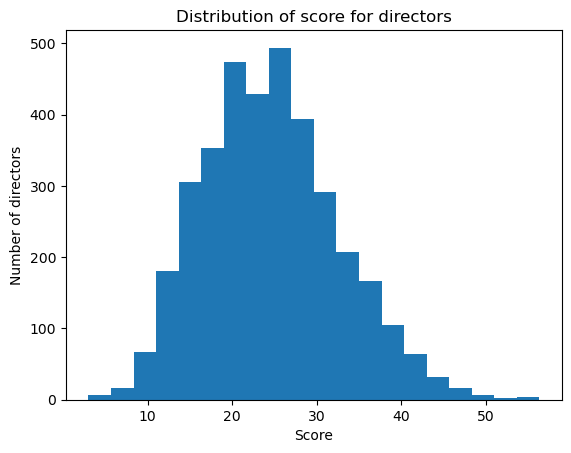

In [87]:
directors_with_score['avg-3'].plot.hist(bins=20)
plt.xlabel('Score')
plt.ylabel('Number of directors')
plt.title('Distribution of score for directors')
plt.show()


In [88]:
chractor_with_director_with_score=pd.merge(character_movie_directors, directors_with_score, left_on=['directors','primaryName'], right_on=['directors','primaryName'], how='left')
chractor_with_director_with_score=chractor_with_director_with_score[['directors','primaryName','avg-3','avg-5','Movie name','Character name','movieid_charactername','topic']]
display(chractor_with_director_with_score.head())

,directors,primaryName,avg-3,avg-5,Movie name,Character name,movieid_charactername,topic
0,nm0432380,Miranda July,NaN,NaN,Me and You and Everyone We Know,Andrew,2238856_Andrew,26
1,nm0432380,Miranda July,NaN,NaN,Me and You and Everyone We Know,Heather,2238856_Heather,31
2,nm0432380,Miranda July,NaN,NaN,Me and You and Everyone We Know,Pam,2238856_Pam,30
3,nm0005436,John Singleton,35.951712,33.123742,Baby Boy,Yvette,156558_Yvette,31
4,nm0005436,John Singleton,35.951712,33.123742,Baby Boy,Jody,156558_Jody,31


In [89]:
# Check missing value for score, on column avg-3
print('There are {} missing value when using score avg-3'.format(directors_with_score['avg-3'].isnull().sum()))
print('There are {} missing value when using score avg-5'.format(directors_with_score['avg-5'].isnull().sum()))


There are 3323 missing value when using score avg-3
There are 4564 missing value when using score avg-5


In the earlier examination of director success scores, it was noted that both avg-3 and avg-5 exhibit robustness. Since avg-3 has fewer missing values, it will be employed as the score for assessing the success of directors.

In [90]:
#Create a new dataframe with director name, score, a list of 'Character name', and corresponding chractor topics to show the chractor choice of success directors
chractor_director_score=chractor_with_director_with_score.groupby(['directors','primaryName','avg-3'])[['Character name','topic']].agg(lambda x: list(x)).reset_index()
chractor_director_score=chractor_director_score.sort_values(by='avg-3', ascending=False).reset_index(drop=True)
display(chractor_director_score.head())

,directors,primaryName,avg-3,Character name,topic
0,nm0634240,Christopher Nolan,56.359359,"[John Blake, Batman, Bane, Miranda Tate, Luciu...","[15, 31, 47, 30, 22, 21, 23, 11, 40, 9, 7, 14,..."
1,nm0001392,Peter Jackson,55.600284,"[Frank Bannister, Ray Lynskey, Milton Dammers,...","[45, 49, 39, 41, 29, 31, 5, 18, 4, 42, 22, 26,..."
2,nm0000338,Francis Ford Coppola,54.015733,"[Dixie Dwyer, Sandman Williams, Vera Cicero, O...","[40, 28, 4, 13, 26, 48, 27, 45, 40, 13, 15, 20..."
3,nm0000233,Quentin Tarantino,53.710729,"[Jackie Brown, Ordell Robbie, Max Cherry, Mela...","[35, 8, 11, 26, 49, 8, 0, 30, 14, 2, 31, 42, 3..."
4,nm0000229,Steven Spielberg,52.930622,"[Lyons, Gunther, Albert, Friedrich, Emilie, Ma...","[29, 20, 14, 43, 12, 45, 33, 22, 22, 39, 8, 4,..."


In [91]:
director_topic=chractor_director_score[['primaryName','topic']].reset_index(drop=True)

Before checking out successful directors, let's first see the distribution of character types chosen by all directors.

In [92]:
# Get the most frequenct n topics of top n directors
def get_topn_topic(n_director=10, n_topic=50):
    if n_director>len(director_topic):
        print('The number of directors is less than the number of directors you want to get, please input a smaller number')
        return
    elif n_director==0:
        n_director=len(director_topic)
    topic_list=[]
    for i in range(n_director):
        topic_list.extend(director_topic['topic'][i])
    topic_list=pd.Series(topic_list)
    topn_topic=topic_list.value_counts()[:n_topic].index.tolist()
    topic_dist=topic_list.value_counts()[:n_topic].values.tolist()
    return topn_topic, topic_dist

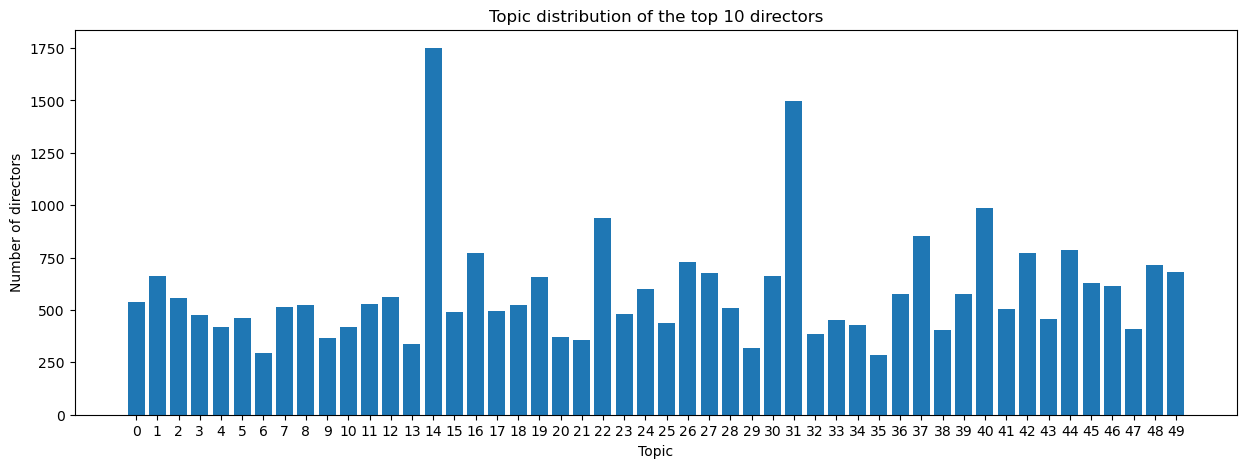

In [93]:
# Visualize the topic distribution for all directors
topn_topicn,topic_dist=get_topn_topic(n_director=0, n_topic=50)

plt.figure(figsize=(15,5))
plt.bar(topn_topicn, topic_dist)
plt.xlabel('Topic')
plt.ylabel('Number of directors')
plt.title('Topic distribution of the top 10 directors')
plt.xticks(topn_topicn)
plt.show()

In [94]:
def print_topn_directors_topics(n=10):
    for i in range(n):
        print('{}: {}'.format(director_topic['primaryName'][i], sorted(set(pd.Series(director_topic['topic'][i]).unique()))))
print('Top 10 directors and their choice of chracters:')
print_topn_directors_topics(n=10)

Top 10 directors and their choice of chracters:
Christopher Nolan: [1, 7, 8, 9, 11, 12, 14, 15, 16, 20, 21, 22, 23, 26, 27, 30, 31, 32, 35, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Peter Jackson: [1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 14, 15, 17, 18, 21, 22, 23, 24, 26, 29, 30, 31, 33, 36, 39, 41, 42, 44, 45, 47, 48, 49]
Francis Ford Coppola: [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 15, 16, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 36, 37, 38, 40, 41, 42, 44, 45, 48, 49]
Quentin Tarantino: [0, 1, 2, 6, 8, 9, 11, 14, 15, 16, 21, 22, 26, 28, 30, 31, 32, 33, 34, 35, 37, 38, 39, 42, 44, 45, 46, 49]
Steven Spielberg: [0, 2, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 49]
Martin Scorsese: [0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 14, 16, 17, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 43, 44, 45, 48]
David Fincher: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19

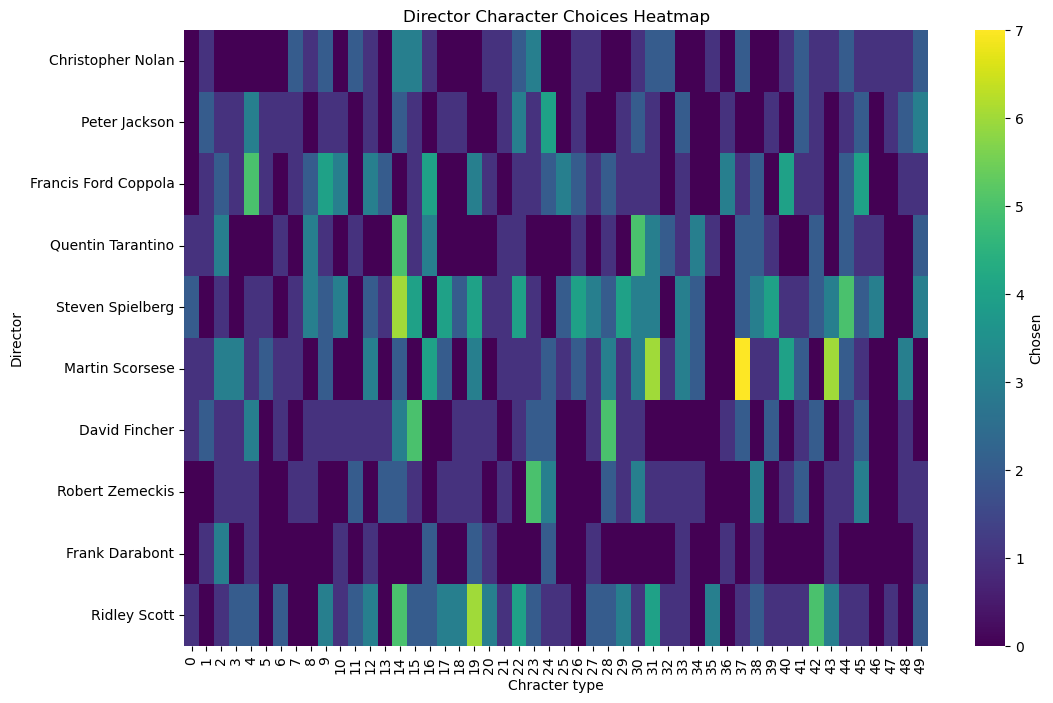

In [123]:
director_topic_top10=director_topic[:10]
matrix = np.zeros((10, 50))
directors_name=director_topic_top10['primaryName'].tolist()

for i, row in director_topic_top10.iterrows():
    for character in row['topic']:
        matrix[i, character] +=1

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(matrix, cmap='viridis', cbar_kws={'label': 'Chosen times'})
plt.xlabel('Chracter type')
plt.ylabel('Director')
plt.yticks(np.arange(0.5, 10.5), directors_name, rotation=0)
plt.title('Director Character Choices Heatmap')
plt.show()

We can observe that most of top10 directors they worked with various types of chractors. Let's have a closer look with it.

In [18]:
# Get the data frame for the top 10 words of topics of the LDA model we used for chractor type annotation
lda_topic_words = pd.read_csv(os.path.join(DATA_PATH_GENERATED, 'annotations_2023/topic_top_words.txt'), sep=":", header=None, names=['topic', 'top_words'])
lda_topic_words['topic']=lda_topic_words['topic'].str.replace('Topic ', '')
# display(lda_topic_words.head())

In [19]:
topn_topicn,_=get_topn_topic(n_director=10, n_topic=5)
print('The top 5 topics of the top 10 directors are: {}\n'.format(topn_topicn))
print('Following are the top 10 wrods of each topic:')
for i in topn_topicn:
    print('Topic {}: {}'.format(i, lda_topic_words[lda_topic_words['topic']==str(i)]['top_words'].values[0]))

The top 5 topics of the top 10 directors are: [14, 31, 19, 30, 15]

Following are the top 10 wrods of each topic:
Topic 14:  tell take find leave try give visit admit agree return
Topic 31:  see ask tell find go refuse leave get give try
Topic 19:  officer hire general detective david major assign film artist pilot
Topic 30:  wife girl plan befriend member martin wound ex expose minister
Topic 15:  john professor perform rao consider guy intervene transform count dump


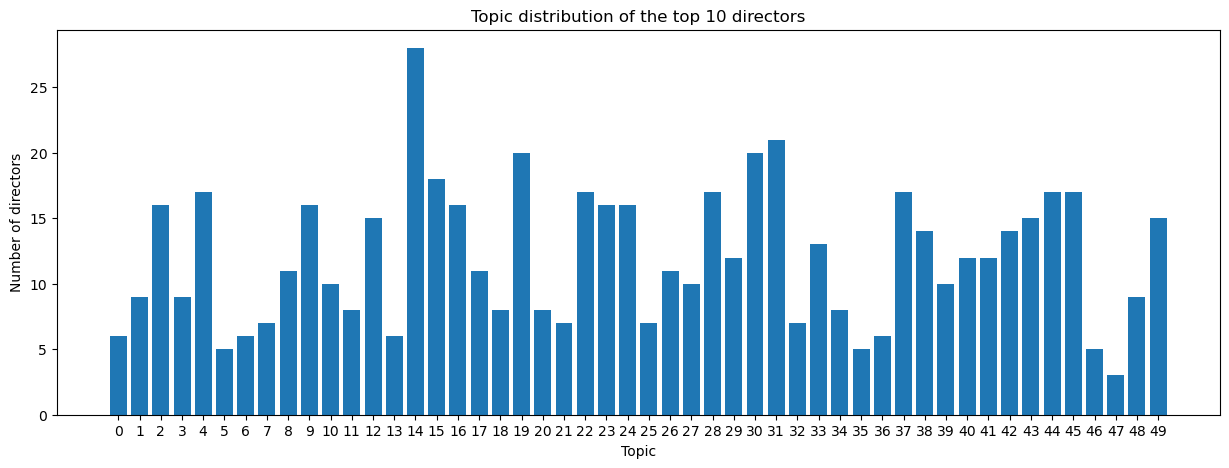

In [20]:
# Visualize the topic distribution of the top 10 directors
topn_topicn,topic_dist=get_topn_topic(n_director=10, n_topic=50)

plt.figure(figsize=(15,5))
plt.bar(topn_topicn, topic_dist)
plt.xlabel('Topic')
plt.ylabel('Number of directors')
plt.title('Topic distribution of the top 10 directors')
plt.xticks(topn_topicn)
plt.show()

# 3.2 How diverse the directors are in their character choices ? 

In [21]:
# Group by directors
directors_group = character_movie_directors.groupby('directors').agg({'Wikipedia movie ID': lambda x: list(x), 'Freebase movie ID': lambda x: list(x), 'Movie name': lambda x: list(x), 'Character name': lambda x: list(x), 'topic': lambda x: list(x), 'tconst': lambda x: list(x),'primaryName':lambda x: list(x)})
# character_movie_directors_group.head(3)
print('There are {} unique directors who has the chracter type information'.format(directors_group.shape[0]))

There are 6941 unique directors who has the chracter type information


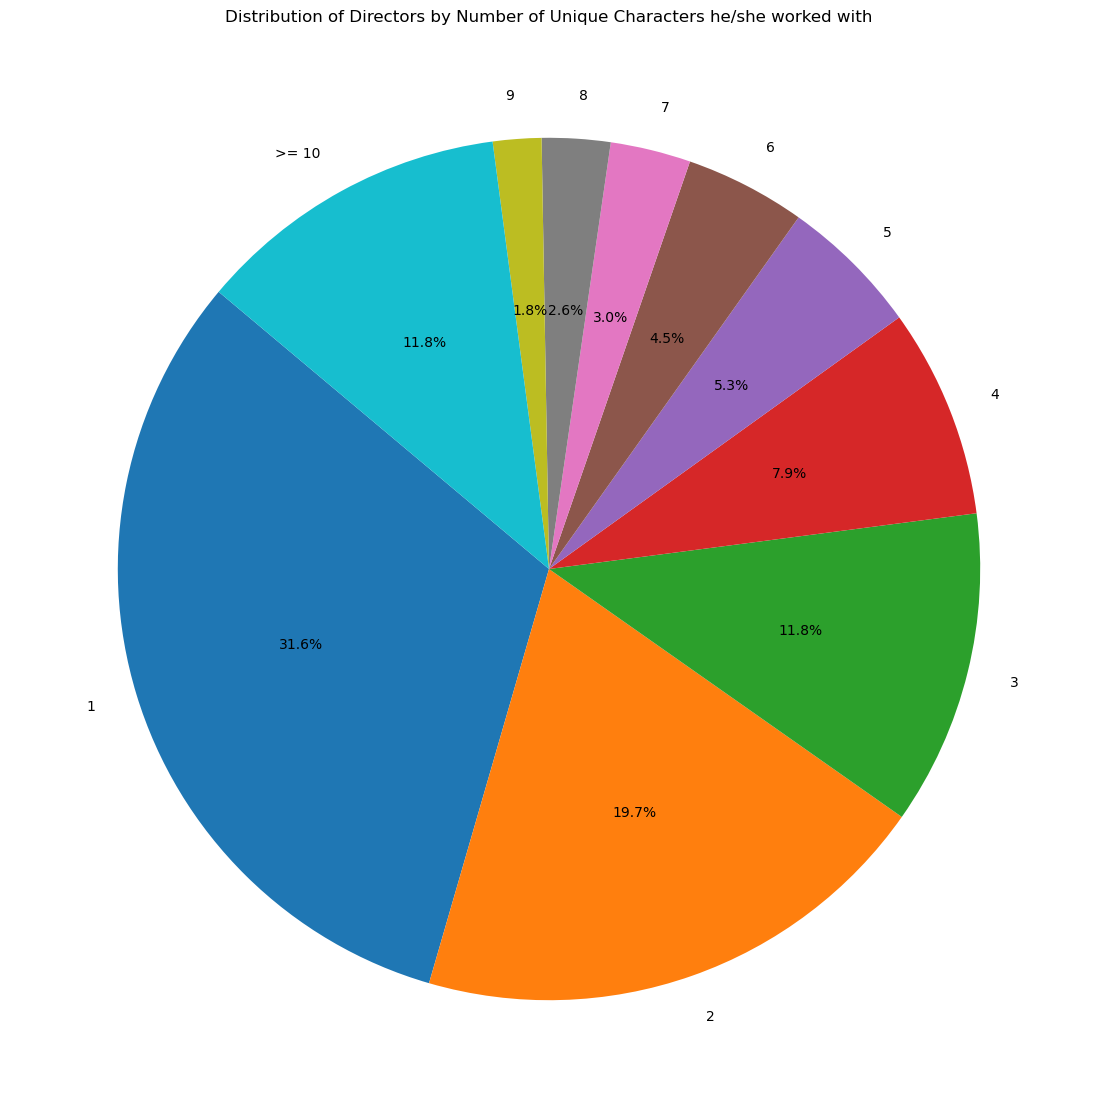

In [22]:
# Calculate the number of unique characters for each director
unique_characters = character_movie_directors.groupby('directors')['topic'].nunique()

# Count the number of directors for each unique number of characters
directors_by_unique_count = unique_characters.value_counts()

# Group together directors with more than 10 unique characters
threshold = 10
large_counts = directors_by_unique_count[directors_by_unique_count.index >= threshold]
directors_by_unique_count = directors_by_unique_count.drop(large_counts.index)
directors_by_unique_count[f'>= {threshold}'] = large_counts.sum()

# Create a pie chart to show the distribution with a custom color map
labels = directors_by_unique_count.index.astype(str)
sizes = directors_by_unique_count.values
colors = plt.cm.tab10(range(len(labels)))

plt.figure(figsize=(14, 14))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Directors by Number of Unique Characters he/she worked with')
plt.show()

Let's have a close look of ten directors with the highest diversity

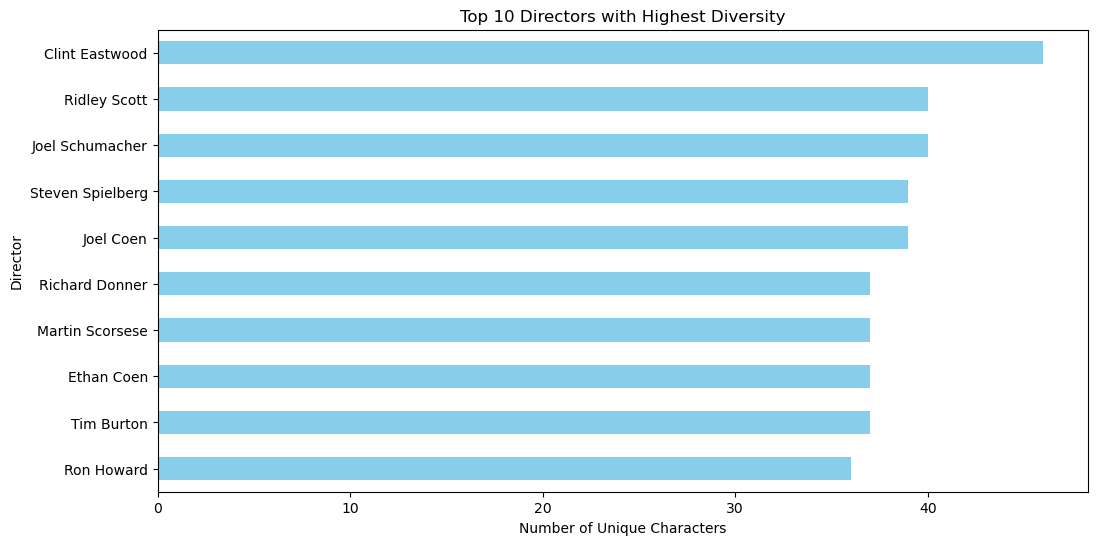

In [23]:
# Calculate the number of unique characters for each director
unique_characters = character_movie_directors.groupby('directors')['topic'].nunique()

# Map director IDs to corresponding 'primaryName'
directors_mapping = character_movie_directors.set_index('directors')['primaryName'].to_dict()
unique_characters.index = unique_characters.index.map(directors_mapping)

# Sort directors based on diversity
sorted_directors = unique_characters.sort_values()

# Visualize the ten directors with the highest diversity
plt.figure(figsize=(12, 6))
sorted_directors.tail(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Directors with Highest Diversity')
plt.xlabel('Number of Unique Characters')
plt.ylabel('Director')
plt.show()

From the above pie chart, we can observe that almost half of the directors only worked with one or two chractor type. However, using this method to define the diversity of directors' chatacter choices  might be subject to the influence of the total number of movies each director has undertaken. To achieve a more precise quantification of the diversity in directors' character choices, we need a more refined quantitative method.

#### Quantify diversity
For quantify diversity, we calculate the Shannon diversity index with normalization for each director based on the distribution of chracter types in their movies. Higher entropy values indicate grater diversity.

In [24]:
# Calculate the Shannon Diversity Index with normalization by the number of chractors
director_diversity = character_movie_directors.groupby('directors')['topic'].apply(lambda x: entropy(pd.Series(x).value_counts() / len(x)))

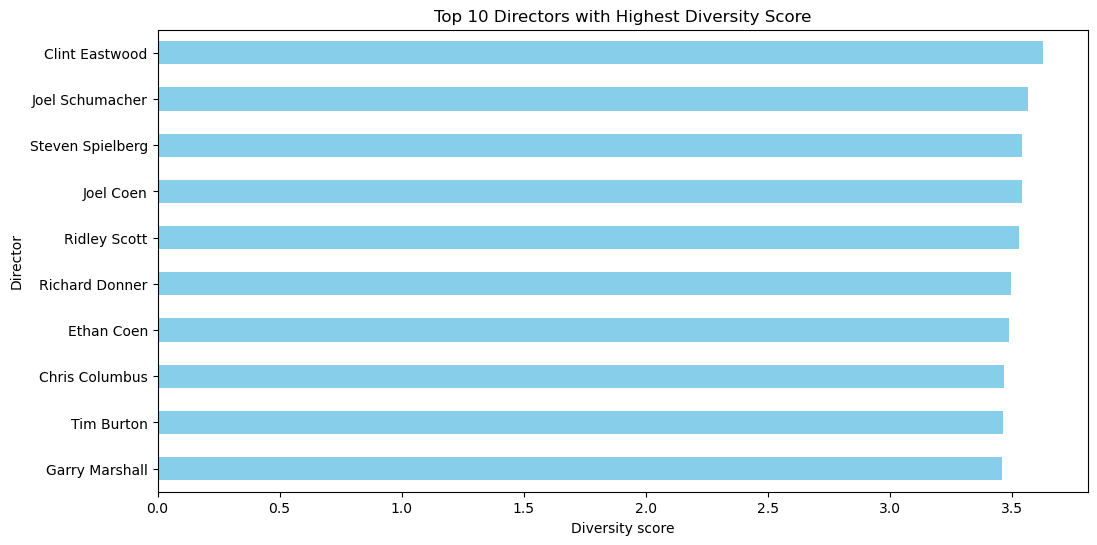

In [25]:
# Visualize the ten directors with the highest diversity

# Map director IDs to corresponding 'primaryName'
director_diversity_map=copy.deepcopy(director_diversity)
director_diversity_map.index = director_diversity_map.index.map(directors_mapping)

# Sort directors based on diversity
sorted_director_diversity = director_diversity_map.sort_values()

plt.figure(figsize=(12, 6))
sorted_director_diversity.tail(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Directors with Highest Diversity Score')
plt.xlabel('Diversity score')
plt.ylabel('Director')
plt.show()

In [26]:
color_category={'0': 'tab:orange', '0.00-1.00': 'tab:green', '1.00-2.00': 'tab:blue', '2.00-3.00': 'tab:red', '3.00-4.00': 'tab:purple'}

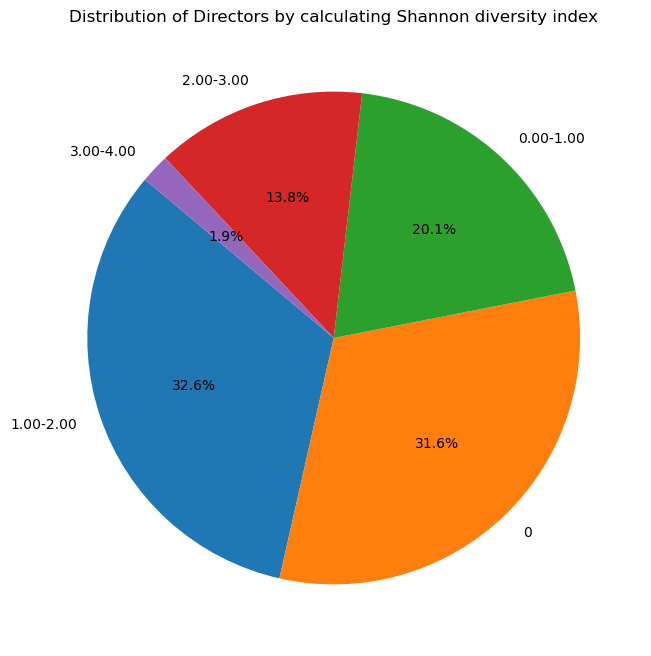

In [27]:
# Create a pie chart to show the distribution of diversity scores

# Define bins for categorizing diversity scores
bins = [-1e-10, 1e-10, 1, 2, 3, 4] 

# Categorize directors based on diversity scores
diversity_categories = pd.cut(sorted_director_diversity, bins=bins, include_lowest=True)

# Calculate the percentage of directors in each category
percentage_by_category = diversity_categories.value_counts(normalize=False) * 100

labels = [f'{category.left:.2f}-{category.right:.2f}' if category.left > 0 else '0' for category in percentage_by_category.index]
sizes = percentage_by_category.values
# Assigning colors based on categories
colors = [color_category[label] for label in labels]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Directors by calculating Shannon diversity index')
plt.show()

Based on the information presented in the pie chart, it is evident that 32.6% of directors exhibit a diversity score falling within the 1-2 range. Additionally, 31.6% of directors possess a diversity score of 0, indicating that their works predominantly feature a single character type. It's worth noting that this might be influenced by the limitations of the plot data available from CMU, as not all movies and characters have sufficient information to determine character types accurately. In the 0-1 range, 20.1% of directors fall into this category, while 13.8% fall within the 2-3 range. Notably, only 1.9% of directors attain a score of 3-4, indicating a higher diversity of character types in their works.

# 3.3 Can we find very successful directors that always use the same type of characters or others that vary a lot in their personas choices ?

In [28]:
director_with_diversescore=pd.merge(pd.DataFrame(director_diversity.reset_index()), directors_with_score, how='left', left_on='directors', right_on='directors')
director_with_diversescore.rename(columns={'topic':'diversity_score'}, inplace=True)
director_with_diversescore.sort_values(by='avg-3', ascending=False, inplace=True)
display(director_with_diversescore.head())

,directors,diversity_score,primaryName,birthYear,deathYear,hits-30,hits-40,hits-45,hits-50,rate-7.0,rate-7.5,rate-8.0,rate-8.5,avg-3,avg-5,avg-10
3707,nm0634240,3.312327,Christopher Nolan,1970,<NA>,9.0,7.0,7.0,7.0,10.0,8.0,7.0,4.0,56.359359,54.764240,48.277678
291,nm0001392,3.347519,Peter Jackson,1961,<NA>,9.0,4.0,3.0,3.0,8.0,4.0,3.0,3.0,55.600284,48.992753,40.917419
77,nm0000338,3.422818,Francis Ford Coppola,1939,<NA>,10.0,4.0,3.0,2.0,10.0,6.0,4.0,3.0,54.015733,48.884288,42.252444
60,nm0000233,3.164872,Quentin Tarantino,1963,<NA>,11.0,8.0,7.0,4.0,10.0,9.0,7.0,2.0,53.710729,52.175466,47.488598
57,nm0000229,3.540218,Steven Spielberg,1946,<NA>,25.0,13.0,7.0,3.0,21.0,15.0,7.0,2.0,52.930622,51.378904,48.343442


In [29]:
def get_topn_directors_diversityscore(n=10):
    return director_with_diversescore[:n].sort_values(by='avg-3')

<Figure size 1200x600 with 0 Axes>

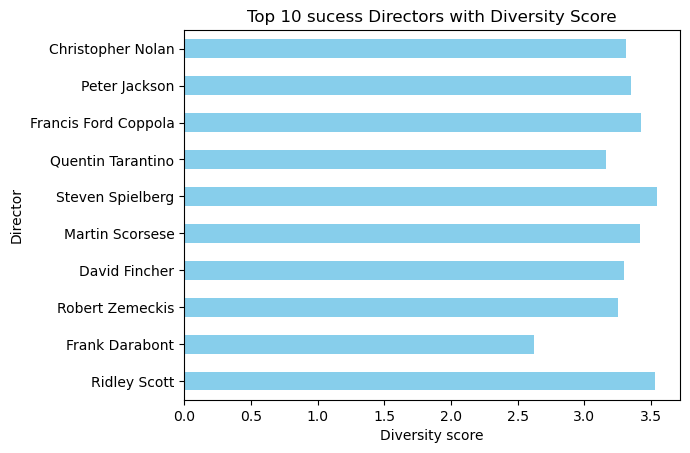

In [30]:
# Visualize the top ten most "success" directors with their diversity score
plt.figure(figsize=(12, 6))
director_with_diversescore_10=get_topn_directors_diversityscore(n=10)
director_with_diversescore_10.tail(10).plot(kind='barh', x='primaryName', y='diversity_score', color='skyblue', legend=False)
plt.title('Top 10 sucess Directors with Diversity Score')
plt.xlabel('Diversity score')
plt.ylabel('Director')
plt.show()

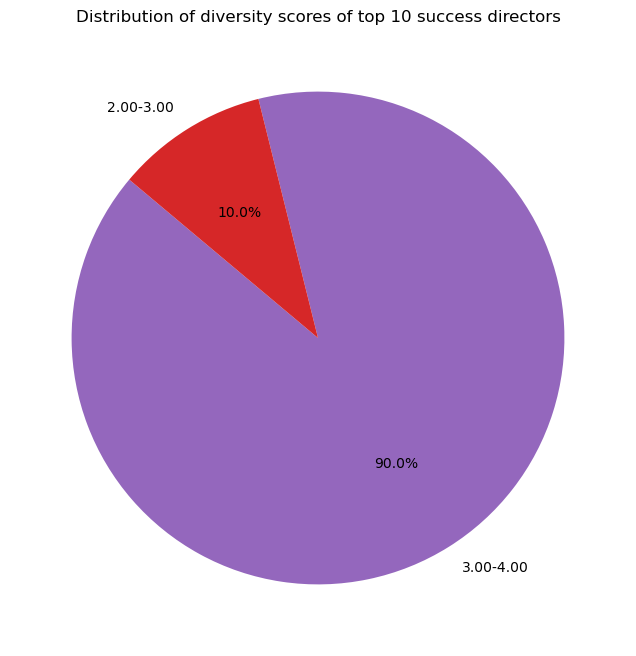

In [31]:
# Categorize directors based on diversity scores
bins = [-1e-10, 1e-10, 1, 2, 3, 4] 
success_diversity_categories = pd.cut(director_diversity, bins=bins, include_lowest=True)

# Create a pie chart to show the distribution of diversity scores of top 10 success directors
percentage_by_category_10 = success_diversity_categories[director_with_diversescore_10.directors].value_counts(normalize=False) * 100
percentage_by_category_10=percentage_by_category_10[percentage_by_category_10!=0]
labels = [f'{category.left:.2f}-{category.right:.2f}' if category.left > 0 else '0' for category in percentage_by_category_10.index]
sizes = percentage_by_category_10.values
# Assigning colors based on categories
colors = [color_category[label] for label in labels]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of diversity scores of top 10 success directors')
plt.show()



Most successful directors seem to have a diversity score falling between 3 and 4, indicating a high diversity of personas in their movies. Let's explore this further by examining the top 20 successful directors.

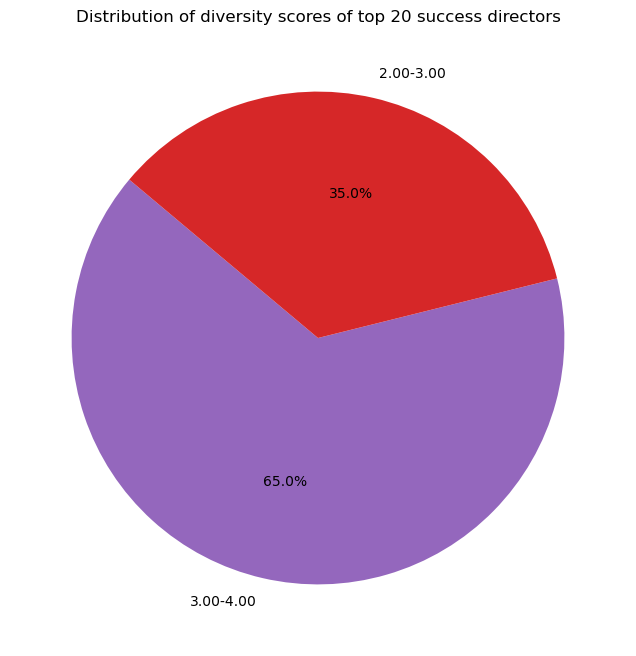

In [32]:
# Create a pie chart to show the distribution of diversity scores of top 20 success directors
director_with_diversescore_20=get_topn_directors_diversityscore(n=20)
percentage_by_category_20 = success_diversity_categories[director_with_diversescore_20.directors].value_counts(normalize=False) * 100
percentage_by_category_20=percentage_by_category_20[percentage_by_category_20!=0]
labels = [f'{category.left:.2f}-{category.right:.2f}' if category.left > 0 else '0' for category in percentage_by_category_20.index]
sizes = percentage_by_category_20.values
# Assigning colors based on categories
colors = [color_category[label] for label in labels]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of diversity scores of top 20 success directors')
plt.show()

We can observe that the distribution of lower diversity score boecome larger. Let's see more.

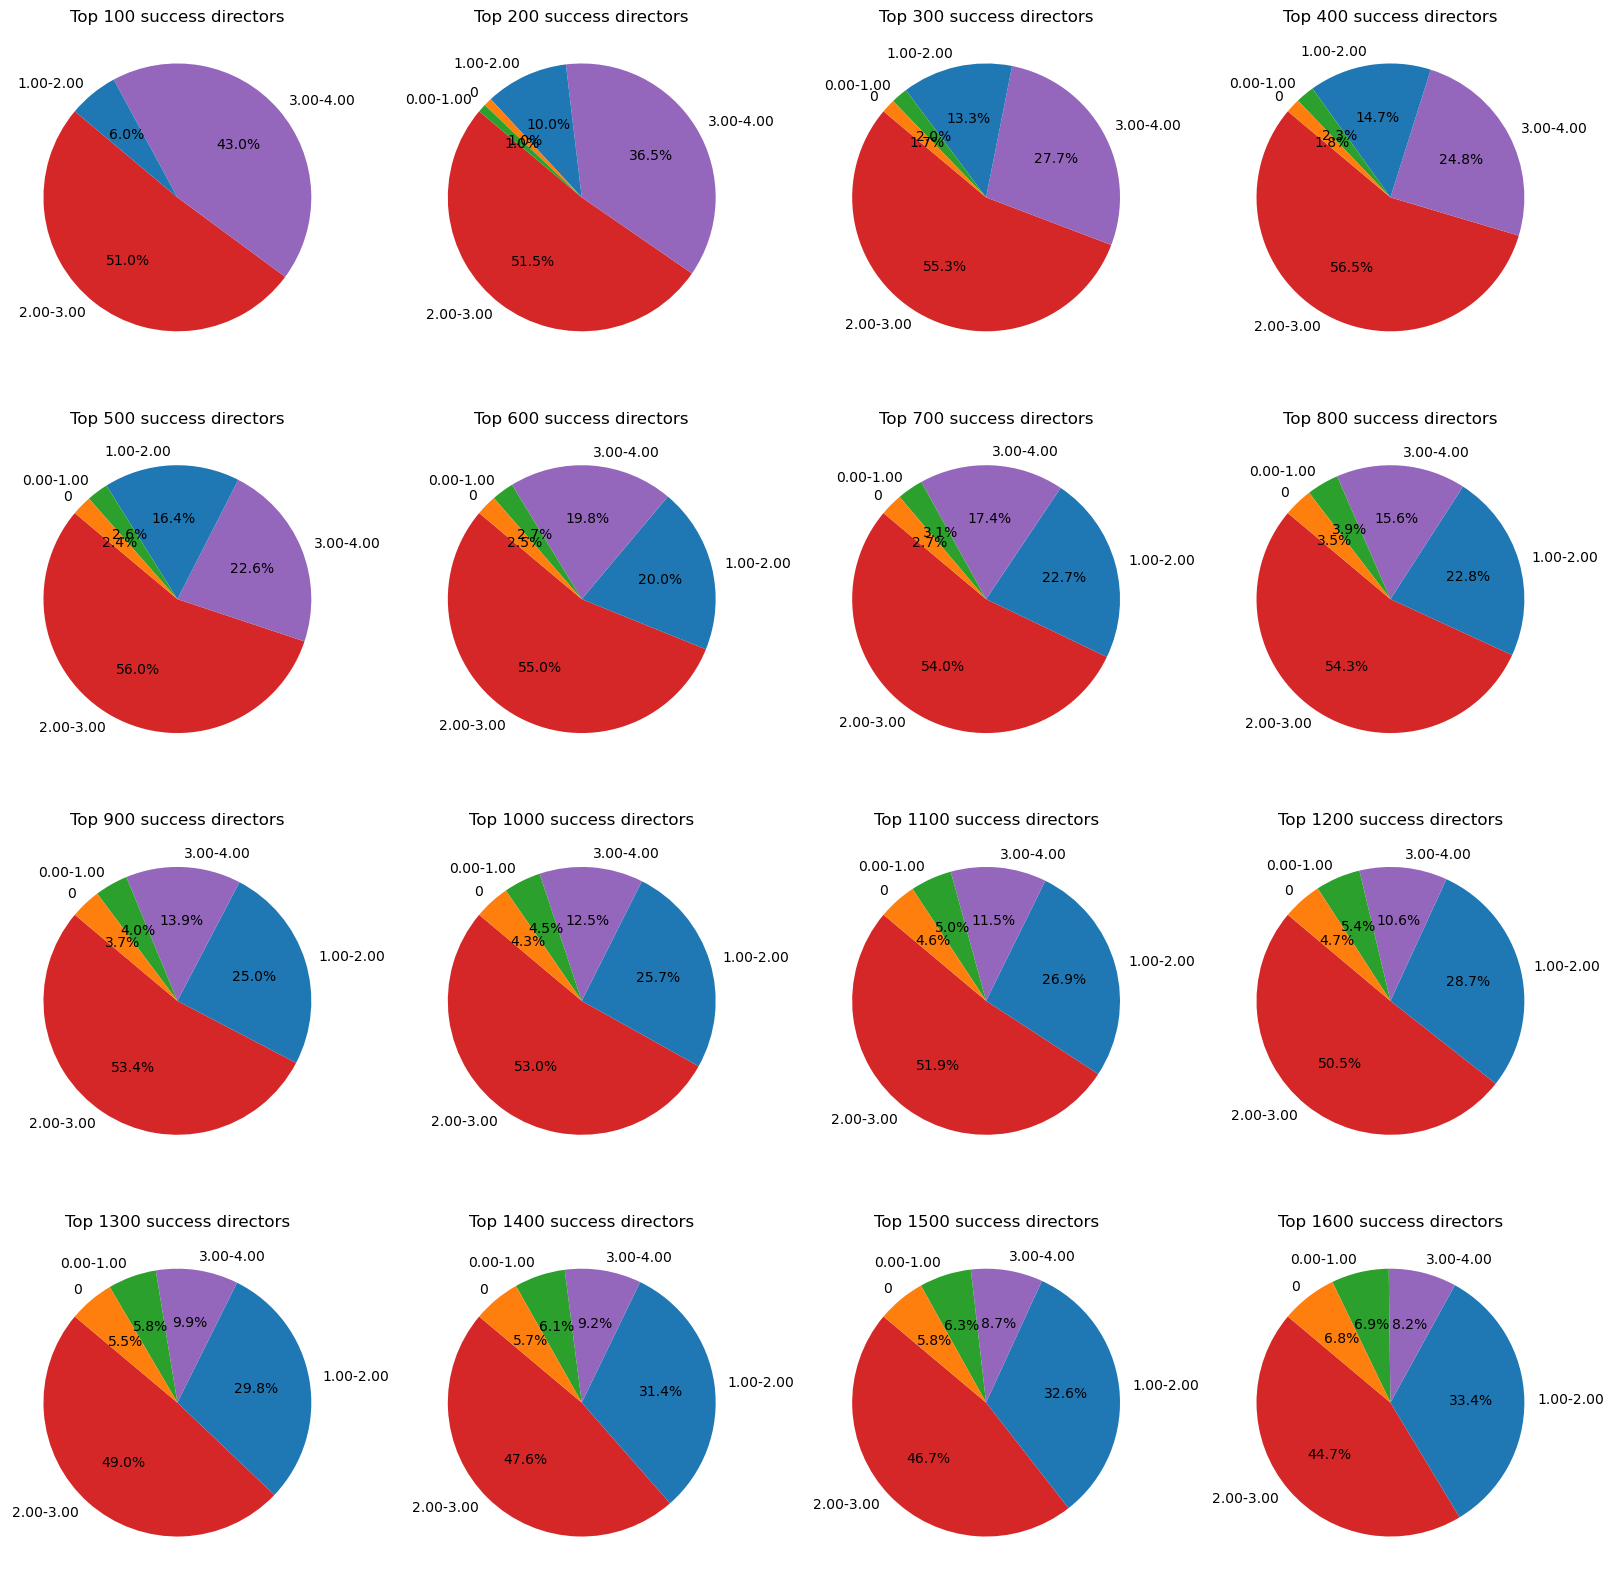

In [33]:
plt.figure(figsize=(20, 20))

for i in range(1,17):
    number=i*100
    director_with_diversescore_n=get_topn_directors_diversityscore(n=number)
    percentage_by_category_n = success_diversity_categories[director_with_diversescore_n.directors].value_counts(normalize=False) * 100
    percentage_by_category_n=percentage_by_category_n[percentage_by_category_n!=0]
    labels = [f'{category.left:.2f}-{category.right:.2f}' if category.left > 0 else '0' for category in percentage_by_category_n.index]
    sizes = percentage_by_category_n.values
    # Assigning colors based on categories
    colors = [color_category[label] for label in labels]

    plt.subplot(4,4,i)
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title('Top {} success directors'.format(number))
plt.show()

Here, we notice that as more top successful directors are included, the distribution of high diversity scores decreases. This prompts the question: is there a correlation between the diversity of character types and the success of directors? 

In [34]:
#rename the columns
director_with_diversescore.rename(columns={'avg-3':'director_score'}, inplace=True)

In [35]:
# Declares a linear regression model
model = smf.ols(formula='director_score ~ diversity_score', data=director_with_diversescore).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         director_score   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     2348.
Date:                Thu, 21 Dec 2023   Prob (F-statistic):               0.00
Time:                        11:47:39   Log-Likelihood:                -11761.
No. Observations:                3618   AIC:                         2.353e+04
Df Residuals:                    3616   BIC:                         2.354e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          17.3078      0.183     

Let's examine some key findings derived from the analysis. Firstly, the coefficient for diversity_score is 5.3351, indicating that with each unit increase in the diversity score, we anticipate an approximate 5.33-point rise in the director score. Essentially, this implies a positive correlation between the director score and the diversity score. Secondly, the p-value associated with the coefficient is <0.05. This indicates that, within the framework of this model, the coefficients are statistically significant, signifying that the diversity score is indeed valuable in predicting the director score.

# 3.4 In definitive, how does this impact the movie’s success ?

In [36]:
movies=pd.read_parquet(os.path.join(DATA_PATH_GENERATED, "movie_with_score.parquet"), engine='pyarrow')

In [37]:
movies_with_socres=copy.deepcopy(movies)
movies_with_socres=movies_with_socres.reset_index().drop(['revenue','rating','votes'], axis=1)

In [38]:
chractor_movie_with_score=pd.merge(character_movie_directors, movies_with_socres, left_on='tconst', right_on='tconst', how='left')
chractor_movie_with_score=chractor_movie_with_score.drop(['Wikipedia movie ID', 'Freebase movie ID', 'Movie name',
     'freebaseID', 'wikipediaID','directors_y','wikipediaID','freebaseID'], axis=1)
#rename directors_x to directors
chractor_movie_with_score.rename(columns={'directors_x':'directors', 'primaryName':'directors_name','Character name':'character_name'}, inplace=True)
chractor_movie_director_with_score=pd.merge(chractor_movie_with_score, director_with_diversescore, left_on='directors', right_on='directors', how='left')
chractor_movie_director_with_score.drop(['primaryName','hits-30', 'hits-40', 'hits-45', 'hits-50',
       'rate-7.0', 'rate-7.5', 'rate-8.0', 'rate-8.5','avg-5','avg-10'], axis=1, inplace=True)
display(chractor_movie_director_with_score.head())

,character_name,tconst,directors,movieid_charactername,topic,topic_dist,directors_name,title,runtime,release,languages,countries,genres,score,diversity_score,birthYear,deathYear,director_score
0,Andrew,tt0415978,nm0432380,2238856_Andrew,26,"[0.01000000000000015, 0.01000000000000015, 0.0...",Miranda July,Me and You and Everyone We Know,91.0,2005,English,"United States of America,United Kingdom","Romantic comedy,Indie,Comedy of manners,Comedy...",32.898986,1.098612,1974,<NA>,NaN
1,Heather,tt0415978,nm0432380,2238856_Heather,31,"[0.245870487647632, 0.005000000000000419, 0.00...",Miranda July,Me and You and Everyone We Know,91.0,2005,English,"United States of America,United Kingdom","Romantic comedy,Indie,Comedy of manners,Comedy...",32.898986,1.098612,1974,<NA>,NaN
2,Pam,tt0415978,nm0432380,2238856_Pam,30,"[0.010000000000000016, 0.010000000000000016, 0...",Miranda July,Me and You and Everyone We Know,91.0,2005,English,"United States of America,United Kingdom","Romantic comedy,Indie,Comedy of manners,Comedy...",32.898986,1.098612,1974,<NA>,NaN
3,Yvette,tt0255819,nm0005436,156558_Yvette,31,"[0.0012500000000002947, 0.0012500000000002947,...",John Singleton,Baby Boy,123.0,2001,English,United States of America,"Crime Fiction,Drama,Coming of age",26.900107,2.952853,1968,2019,35.951712
4,Jody,tt0255819,nm0005436,156558_Jody,31,"[0.0008695652173914489, 0.0008695652173914489,...",John Singleton,Baby Boy,123.0,2001,English,United States of America,"Crime Fiction,Drama,Coming of age",26.900107,2.952853,1968,2019,35.951712


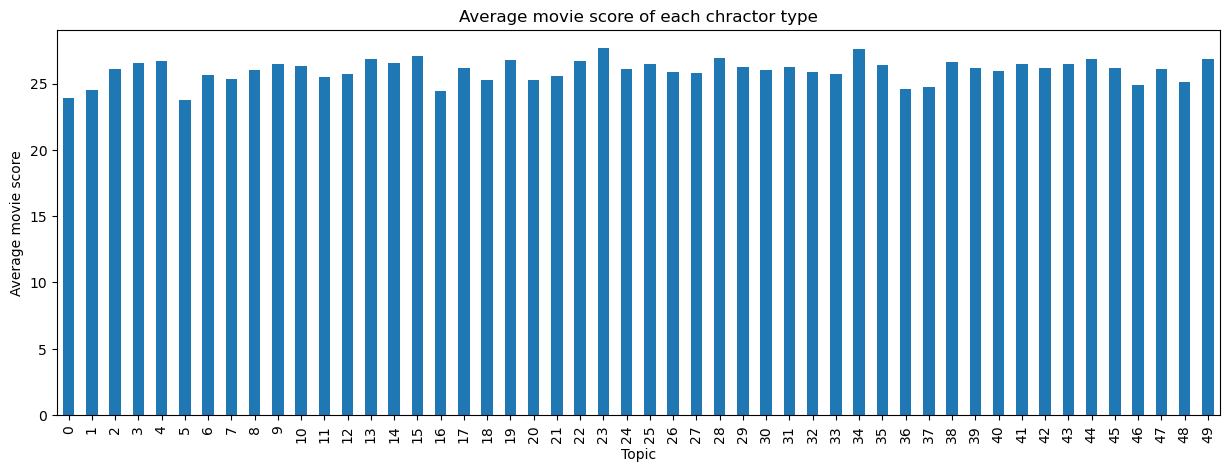

In [39]:
# Plot the average movie score of each chractor type
plt.figure(figsize=(15,5))
chractor_movie_director_with_score.groupby('topic')['score'].mean().plot.bar()
plt.xlabel('Topic')
plt.ylabel('Average movie score')
plt.title('Average movie score of each chractor type')
plt.show()

In the above plot, we can see that the scores for different types of characters are quite similar. Therefore, there isn't a specific character type with a significantly higher movie score. However, let's delve deeper to investigate whether there is a relationship between the movie score and the character type for each directors.

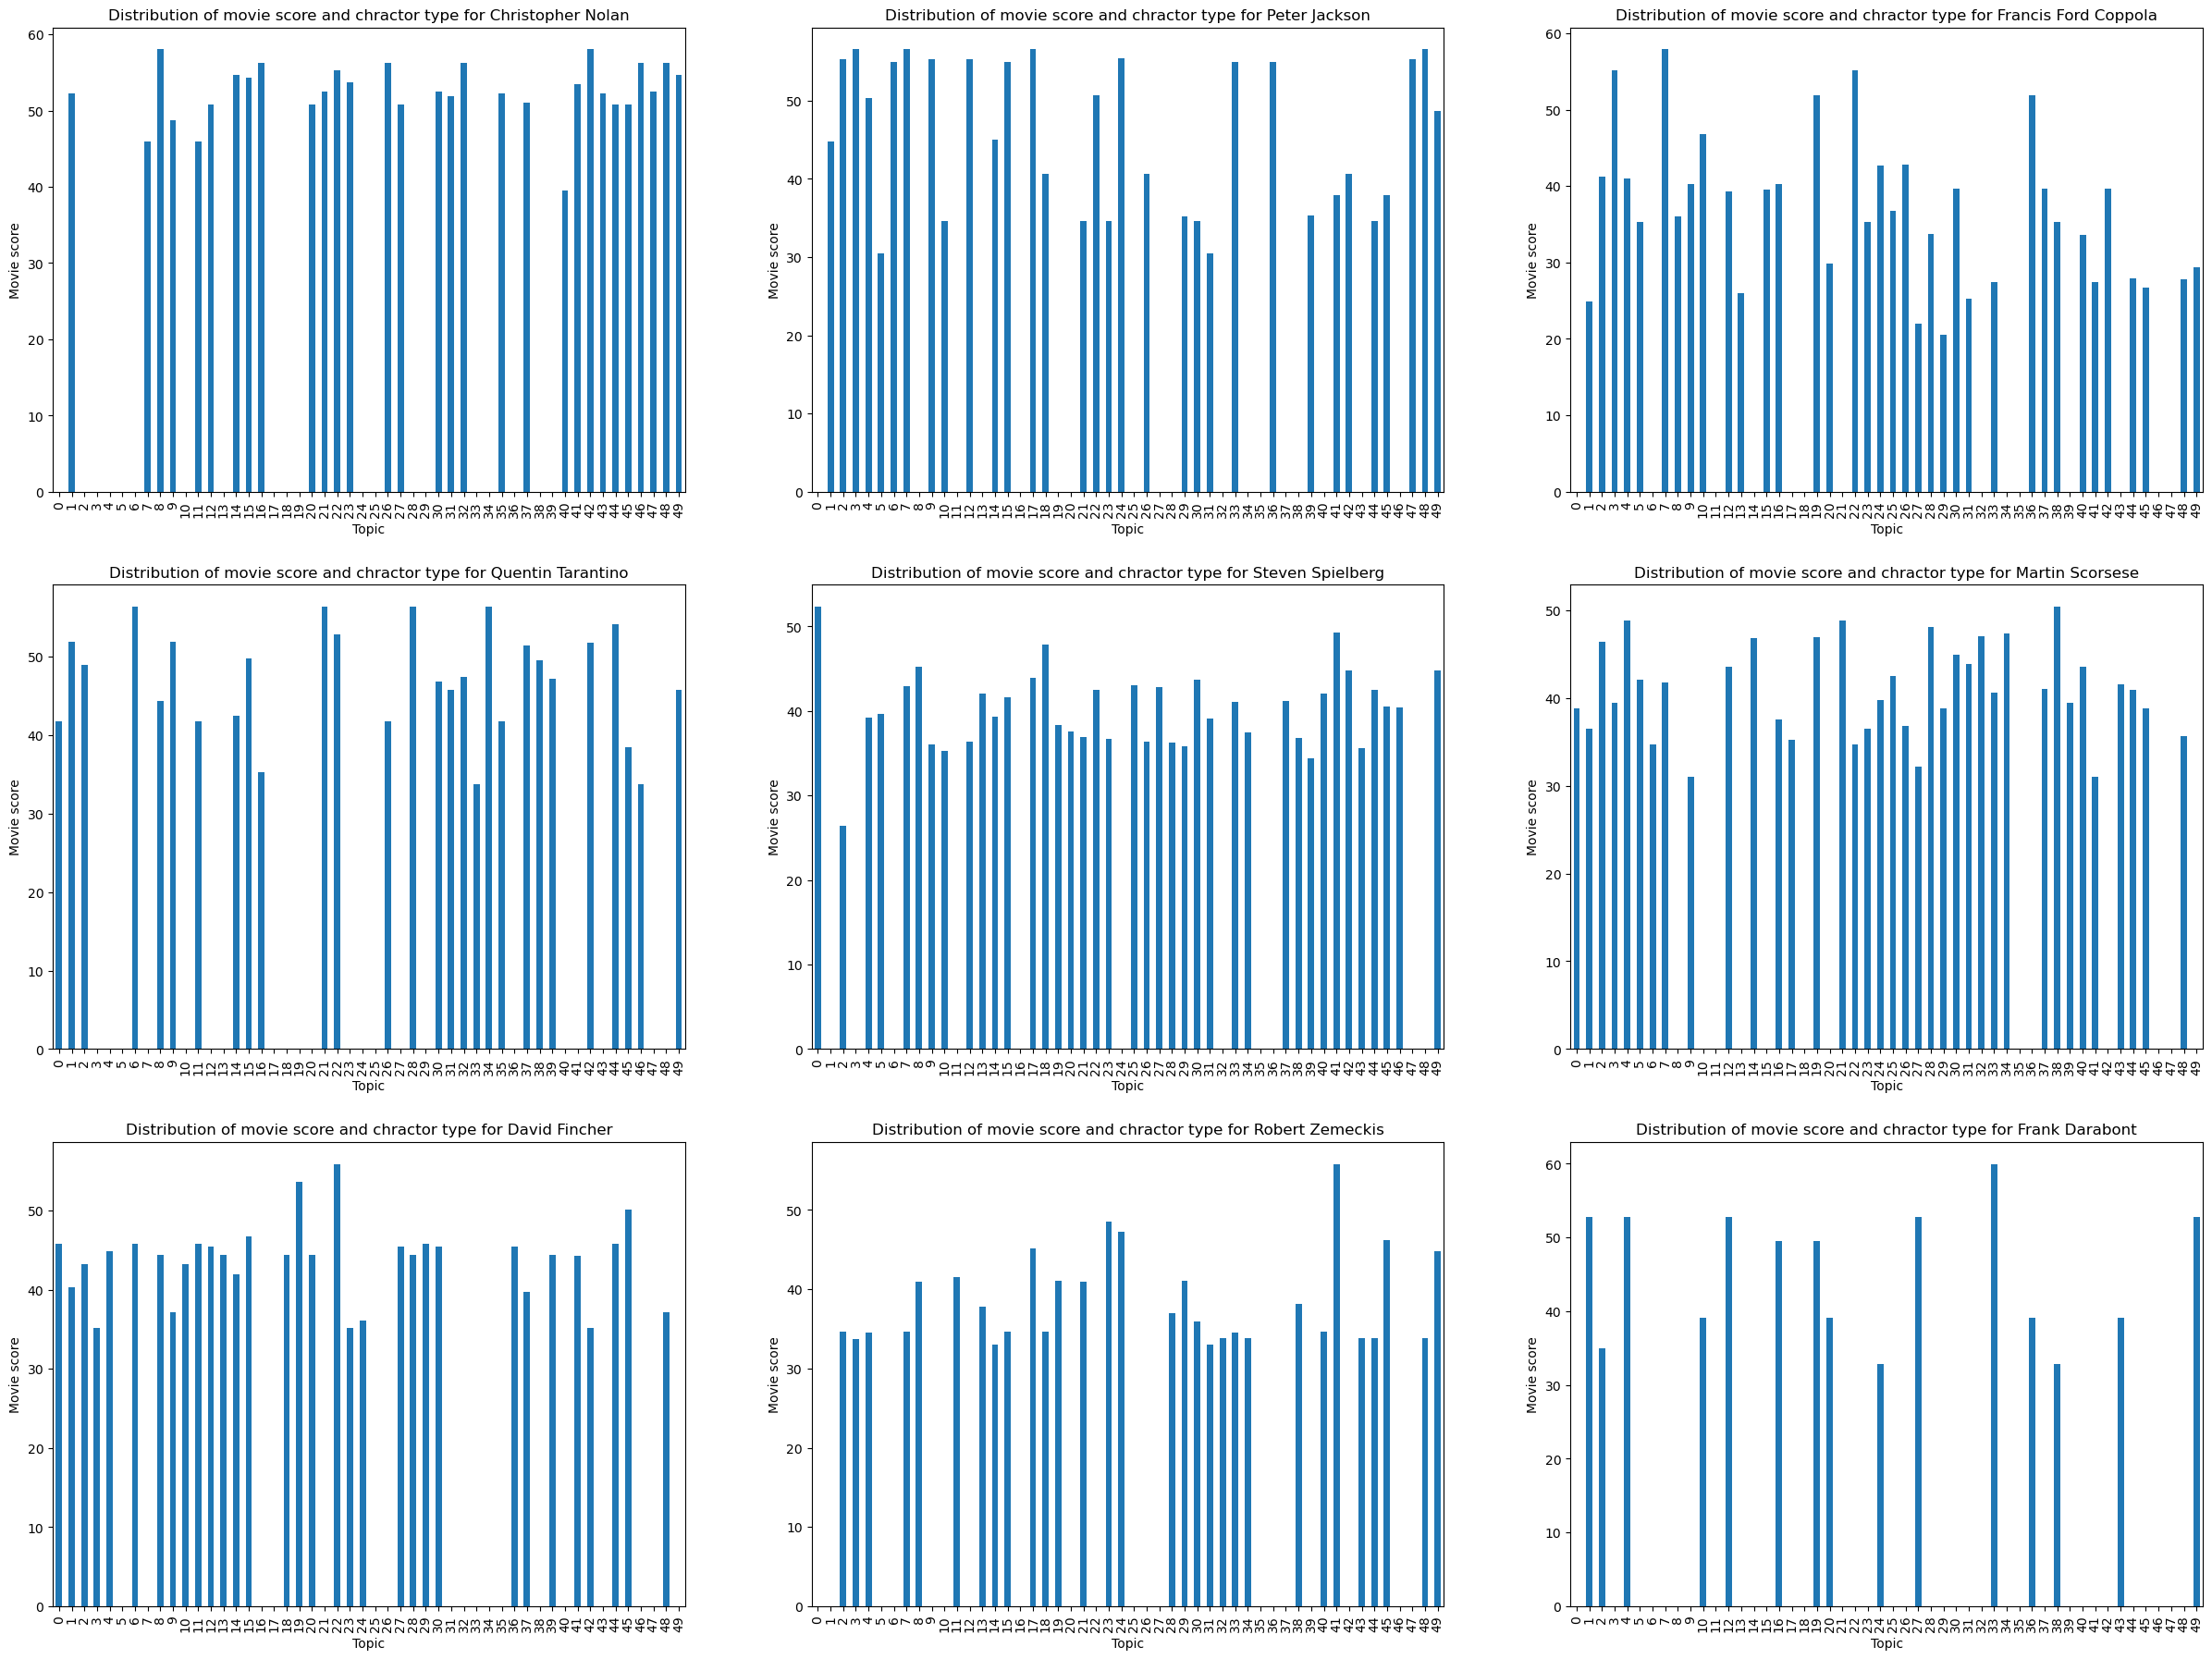

In [40]:
# Get the dirtribution of movie score and chractor type for each director
director_topic_score=chractor_movie_director_with_score.groupby(['directors','topic'])['score'].mean().reset_index()
director_topic_score=director_topic_score.pivot(index='directors', columns='topic', values='score')
director_topic_score=director_topic_score.reset_index()
director_topic_score=director_topic_score.merge(director_with_diversescore[['directors','director_score']], left_on='directors', right_on='directors', how='left')
director_topic_score=director_topic_score.dropna(subset=['director_score'])
director_topic_score=director_topic_score.set_index('directors')
director_topic_score=director_topic_score.sort_values(by='director_score', ascending=False)
director_topic_score=director_topic_score.drop('director_score', axis=1)
director_topic_score=director_topic_score.reset_index()

# The distribution of movie score and chractor type for top 9 success directors
plt.figure(figsize=(30, 30))
for i in range(0,9):
    plt.subplot(4,3,i+1)
    director_topic_score.iloc[i,1:].plot.bar(stacked=True)
    plt.xlabel('Topic')
    plt.ylabel('Movie score')
    plt.title('Distribution of movie score and chractor type for {}'.format(directors_mapping[director_topic_score.iloc[i,0]]))


Returning to the earlier question: does the diversity of character types among a director's works impact the director's success or the success of their movies?

In [41]:
chractor_movie_diversity=chractor_movie_director_with_score.drop_duplicates(subset=['tconst']).reset_index(drop=True)

In [42]:
# Declares a linear regression model
model = smf.ols(formula='score ~ diversity_score', data=chractor_movie_diversity).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     3547.
Date:                Thu, 21 Dec 2023   Prob (F-statistic):               0.00
Time:                        11:47:55   Log-Likelihood:                -49993.
No. Observations:               14452   AIC:                         9.999e+04
Df Residuals:                   14450   BIC:                         1.000e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          16.6105      0.127    1

Let's examine some key findings derived from the analysis. Firstly, the coefficient for diversity_score is 3.7065, indicating that with each unit increase in the diversity score, we anticipate an approximate 3.7-point rise in the movie score. Essentially, this implies a positive correlation between the movie score and the diversity score. Secondly, the p-value associated with the coefficient is <0.05. This indicates that, within the framework of this model, the coefficients are statistically significant, signifying that the diversity score is indeed valuable in predicting the movie score.

In [43]:
avg_score=chractor_movie_diversity['score'].mean()
max_score=chractor_movie_diversity['score'].max()
print('The average score of all movies is {}'.format(avg_score))
print('The max score of all movies is {}'.format(max_score))


The average score of all movies is 23.160657322365054
The max score of all movies is 59.96584023525815


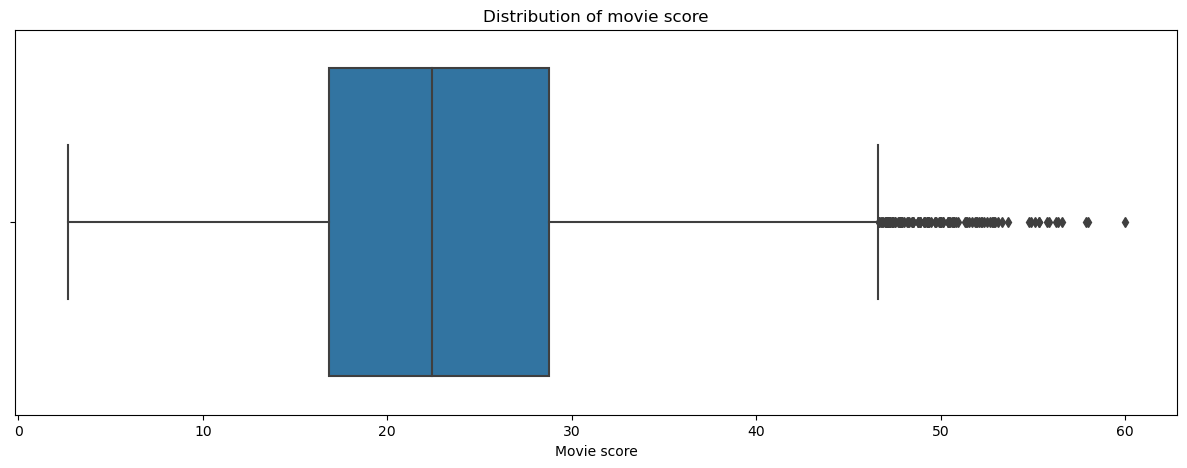

In [44]:
# A box plot to show the distribution of movie score
plt.figure(figsize=(15,5))
sns.boxplot(x=chractor_movie_diversity['score'])
plt.xlabel('Movie score')
plt.title('Distribution of movie score')
plt.show()


In [45]:
chractor_movie_diversity_sucess=copy.deepcopy(chractor_movie_diversity)
chractor_movie_diversity_sucess['movie_sucess']=chractor_movie_diversity_sucess['score'].apply(lambda x: 1 if x>23 else 0)
# print(chractor_movie_diversity_sucess.keys())

In [54]:
treatment_df = chractor_movie_diversity_sucess[chractor_movie_diversity_sucess['movie_sucess'] == True]
control_df = chractor_movie_diversity_sucess[chractor_movie_diversity_sucess['movie_sucess'] == False]
print(len(treatment_df), 'movies in our dataset that considered as sucessed (treatment group).')
print(len(control_df), 'papers in our dataset that considered as sucessed (control group).')

6826 movies in our dataset that considered as sucessed (treatment group).
7694 papers in our dataset that considered as sucessed (control group).


In [50]:
chractor_movie_diversity_sucess.keys()

Index(['character_name', 'tconst', 'directors', 'movieid_charactername',
       'topic', 'topic_dist', 'directors_name', 'title', 'runtime', 'release',
       'languages', 'countries', 'genres', 'score', 'diversity_score',
       'birthYear', 'deathYear', 'director_score', 'movie_sucess'],
      dtype='object')

In [60]:
G = nx.Graph()

for languages in tqdm(chractor_movie_diversity_sucess['languages'].unique()):
    treat_lan_df = treatment_df[treatment_df['languages'] == languages]
    control_lan_df = control_df[control_df['languages'] == languages]
    for countries in treat_lan_df['countries'].unique():
        treat_con_df = treat_lan_df[treat_lan_df['countries'] == countries]
        control_con_df = control_lan_df[control_lan_df['countries'] == countries]
        # for genres in treat_con_df['genres'].unique():
        #     genres=genres.split(',')
        #     treat_gen_df = treat_con_df[treat_con_df['genres'].apply(lambda x: set(x.split(','))).apply(lambda x: bool(x.intersection(set(genres))))]
        #     control_gen_df = control_con_df[control_con_df['genres'].apply(lambda x: set(x.split(','))).apply(lambda x: bool(x.intersection(set(genres))))]
        for control_id, control_row in control_con_df.iterrows():
            for treatment_id, treatment_row in treat_con_df.iterrows():
                # Match papers with exactly the same overall score before rebuttal
                if control_row["director_score"] == treatment_row["director_score"]:
                    G.add_edge(control_id, treatment_id)

matching = nx.maximal_matching(G) # ensure one match

100%|██████████| 800/800 [08:55<00:00,  1.49it/s]   


In [61]:
matched_df = chractor_movie_diversity_sucess.copy()
matched_df['matched_id'] = np.nan

for i, (treatment_index, control_index) in enumerate(matching):
    matched_df.loc[treatment_index, 'matched_id'] = i
    matched_df.loc[control_index, 'matched_id'] = i

matched_df = matched_df.dropna(subset=['matched_id'])


In [67]:
display(matched_df.sort_values(by='matched_id').head(10))
sucess_counts = matched_df['movie_sucess'].value_counts()

print('We have', len(matched_df),'in the resulting dataframe')
print(f"Number of movies are considered as success: {sucess_counts[1]}")
print(f"Number of movies are considered as success: {sucess_counts[0]}")

,character_name,tconst,directors,movieid_charactername,topic,topic_dist,directors_name,title,runtime,release,languages,countries,genres,score,diversity_score,birthYear,deathYear,director_score,movie_sucess,matched_id
10702,Montgomery,tt0039286,nm0229424,42106_Montgomery,12,"[0.010000000000000238, 0.010000000000000238, 0...",Edward Dmytryk,Crossfire,86.0,1947,English,United States of America,"Crime Fiction,Thriller,Black-and-white,Drama,S...",28.978437,3.014630,1908,1999,31.511918,1,0.0
6090,Jo Jones,tt0036418,nm0229424,3334667_Jo Jones,39,"[0.005000000000000225, 0.005000000000000225, 0...",Edward Dmytryk,My Tender Comrade,NaN,1943,English,United States of America,"Drama,Black-and-white",18.498482,3.014630,1908,1999,31.511918,0,0.0
4131,Roberto Orlandi,tt0056424,nm0202681,7553781_Roberto Orlandi,6,"[0.002857142857153055, 0.002857142857153055, 0...",Delmer Daves,Rome Adventure,119.0,1962,English,United States of America,"Road movie,Romance Film,Film adaptation,Drama,...",20.119291,2.718473,1904,1977,31.316176,0,1.0
1790,Tom Jeffords,tt0042286,nm0202681,993532_Tom Jeffords,26,"[0.006666666666689749, 0.006666666666689749, 0...",Delmer Daves,Broken Arrow,93.0,1950,English,United States of America,"Action/Adventure,Western,Action",28.606520,2.718473,1904,1977,31.316176,1,1.0
5471,Ali,tt0422091,nm1189376,1828869_Ali,12,"[0.0025000000000001423, 0.0025000000000001423,...",Sanjay Gadhvi,Dhoom,123.0,2004,Hindi,India,"Thriller,Heist,World cinema,Chase Movie,Buddy ...",28.636441,2.025326,1965,<NA>,25.303603,1,2.0
3107,Vikrant Raina,tt1034449,nm1189376,18711572_Vikrant Raina,0,"[0.5742857142853373, 0.002857142857145467, 0.0...",Sanjay Gadhvi,Kidnap,149.0,2008,Hindi,India,"Thriller,Musical,Bollywood,World cinema",15.662235,2.025326,1965,<NA>,25.303603,0,2.0
11056,Raja,tt0114230,nm0409791,7325516_Raja,44,"[0.08500000115396907, 0.0869615935842196, 0.00...",Indra Kumar,Raja,168.0,1995,Hindi,India,Bollywood,15.193374,2.510008,<NA>,<NA>,27.905896,0,3.0
9140,Prem,tt0406977,nm0409791,30860806_Prem,5,"[0.010000000000000007, 0.010000000000000007, 0...",Indra Kumar,Masti: Sanam Teri Kasam,164.0,2004,Hindi,India,"Romantic comedy,World cinema,Musical,Drama,Com...",23.788739,2.510008,<NA>,<NA>,27.905896,1,3.0
1488,Wilby Daniels,tt0053271,nm0059106,673158_Wilby Daniels,48,"[0.005000000000010534, 0.005000000000010534, 0...",Charles Barton,The Shaggy Dog,104.0,1959,English,United States of America,"Drama,Family Film,Fantasy,Comedy",23.899134,1.039721,1902,1981,27.471889,1,4.0
6398,Breezy Albright,tt0042733,nm0059106,31021585_Breezy Albright,26,"[0.004000000000011445, 0.004000000000011445, 0...",Charles Barton,The Milkman,87.0,1950,English,United States of America,Comedy film,15.552530,1.039721,1902,1981,27.471889,0,4.0


We have 2414 in the resulting dataframe
Number of movies are considered as success: 1207
Number of movies are considered as success: 1207


In [69]:
matched_model = smf.ols(formula='score ~ diversity_score', data=matched_df).fit()

print(matched_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     20.17
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           7.43e-06
Time:                        14:59:17   Log-Likelihood:                -7767.6
No. Observations:                2413   AIC:                         1.554e+04
Df Residuals:                    2411   BIC:                         1.555e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          21.2669      0.473     